<a href="https://colab.research.google.com/github/chrisardo/Ejercicios-desarrollados-en-Sql-/blob/main/SESI%C3%93N_3_PROCEDIMIENTOS_ALMACENADOS_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

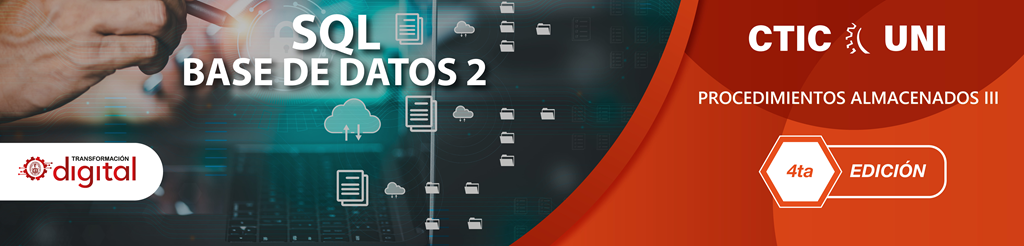

<table border=1 width='99%'>
<tr>
<td bgcolor='#AC2B24'>

# **<font color="#FFFFFF"> PROCEDIMIENTOS ALMACENADOS TRANSACCIONALES</font>**
</td>
</tr>
</table>

<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Consultar sesiones activas</font>**
</td>
</tr>
</table>



```
SELECT
	session_id,
	login_name,
	host_name,
	program_name,
	status,
	last_request_start_time
FROM sys.dm_exec_sessions
WHERE is_user_process = 1;
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Identificar bloqueos (locks)</font>**
</td>
</tr>
</table>



```
SELECT *
FROM sys.dm_tran_locks
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Identificar transacciones abiertas</font>**
</td>
</tr>
</table>



```
SELECT *
FROM sys.dm_tran_active_transactions
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Revisar transacciones largas</font>**
</td>
</tr>
</table>



```
SELECT *
FROM sys.dm_tran_database_transactions
WHERE database_transaction_begin_time < DateADD(MINUTE, -5, GetDate())
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Identificar sesiones bloqueadas</font>**
</td>
</tr>
</table>



```
SELECT *
FROM sys.dm_os_waiting_tasks
WHERE blocking_session_id IS NOT NULL
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Analizar el uso de la memoria por sesión</font>**
</td>
</tr>
</table>



```
SELECT
	session_id,
	memory_usage,
	total_scheduled_time
FROM sys.dm_exec_sessions
WHERE memory_usage > 0
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Identificar consultas con alto consumo de CPU</font>**
</td>
</tr>
</table>



```
SELECT
	qs.total_worker_time / qs.execution_count AS [Promedio de CPU],
	qs.execution_count,
	t.text
FROM sys.dm_exec_query_stats qs
CROSS APPLY sys.dm_exec_sql_text(qs.sql_handle) t
ORDER BY 3 DESC
```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Procedimiento Almacenado de Modificación</font>**
</td>
</tr>
</table>



```
USE Northwind
GO
IF EXISTS
(
    SELECT name
    FROM sys.procedures
    WHERE name = 'usp_order_details_update'
)
DROP PROCEDURE usp_order_details_update
GO
CREATE PROCEDURE usp_order_details_update
(
    @OrderID        int,
    @ProductID        int,
    @UnitPrice        money,
    @Quantity        smallint,
    @Discount        real
)
AS
BEGIN
    DECLARE @ErrorNumber        int
    DECLARE @ErrorSeverity        int
    DECLARE @ErrorState            int
    DECLARE @ErrorProcedure        nvarchar(128)
    DECLARE @ErrorLine            int
    DECLARE @ErrorMessage        nvarchar(4000)
    DECLARE @ErrorDate            datetime

    
    DECLARE @Stock            smallint
    DECLARE @Estado            bit

	DECLARE @Precio            money
	DECLARE @Cantidad          smallint

    DECLARE @strError       VARCHAR(2000)

    BEGIN TRANSACTION
    BEGIN TRY

		SELECT
			@Cantidad = [Quantity]
		FROM  [dbo].[Order Details]
		WHERE
				OrderID = @OrderID
			AND
				ProductID = @ProductID;
        SELECT
            @Precio = [UnitPrice]
            ,@Stock = [UnitsInStock]
            ,@Estado = [Discontinued]
        FROM [dbo].[Products]
        WHERE ProductID = @ProductID

        IF @UnitPrice*(1 - @Discount) < @Precio
        BEGIN
            SET @strError = CONCAT(@UnitPrice*(1-@Discount), ' debe ser >= a ', @Precio);
            THROW 50001, @strError, 1
        END
        IF @Discount > 0.2
        BEGIN
            SET @strError = 'El descuento no puede ser mayor al 20 %%';
            THROW 50002, @strError, 1
        END
        IF @Estado != 0
        BEGIN
            SET @strError = 'No puedes vender este producto porque está descontinuado';
            THROW 50003, @strError, 1
        END
        IF @Quantity > @Stock + @Cantidad
        BEGIN
            SET @strError = CONCAT('Solo tenemos en ', @Stock + @Cantidad, ' unidades de ', @Quantity);
            THROW 50004, @strError, 1
        END

		UPDATE [dbo].[Order Details]
		SET
			[UnitPrice] = @UnitPrice
			,[Quantity] = @Quantity
			,[Discount] = @Discount
		WHERE
				OrderID = @OrderID
			AND
				ProductID = @ProductID

        UPDATE [dbo].[Products]
        SET [UnitsInStock] += @Cantidad - @Quantity
        WHERE [ProductID] = @ProductID;

        COMMIT TRANSACTION;
        RETURN 0
    END TRY
    BEGIN CATCH
		IF @@TRANCOUNT>0
		BEGIN
			SELECT
				@ErrorNumber = ERROR_NUMBER(),
				@ErrorSeverity = ERROR_SEVERITY(),
				@ErrorState = ERROR_STATE(),
				@ErrorProcedure = ERROR_PROCEDURE(),
				@ErrorLine = ERROR_LINE(),
				@ErrorMessage = ERROR_MESSAGE(),
				@ErrorDate = GETDATE()

			ROLLBACK TRANSACTION;

			INSERT INTO [dbo].[tbl_error_usp]
			(
				[ErrorNumber]
				,[ErrorSeverity]
				,[ErrorState]
				,[ErrorProcedure]
				,[ErrorLine]
				,[ErrorMessage]
				,[ErrorDate]
			)
			VALUES
			(
				@ErrorNumber,
				@ErrorSeverity,
				@ErrorState,
				@ErrorProcedure,
				@ErrorLine,
				@ErrorMessage,
				@ErrorDate
			)
			RETURN -1
		END
    END CATCH

END
```





```
USE Northwind
GO
DECLARE @ProductID INT = 2;

SELECT *
FROM [Order Details]
WHERE OrderID = 10248;

SELECT *
FROM Products
WHERE ProductID = @ProductID;

DECLARE @RC int
DECLARE @OrderID int = 10248;
DECLARE @UnitPrice money = 19
DECLARE @Quantity smallint = 15
DECLARE @Discount real = 0

-- TODO: Establezca los valores de los parámetros aquí.

EXECUTE @RC = usp_order_details_insert  
    @OrderID
  ,@ProductID
  ,@UnitPrice
  ,@Quantity
  ,@Discount;

SELECT *
FROM Products
WHERE ProductID = @ProductID;
GO
SELECT *
FROM [Order Details]
WHERE OrderID = 10248;
GO


```



<table width='99%'>
<tr>
<td bgcolor='#FFBA39'>

## **<font color="#000000"> Procedimiento Almacenado de Eliminación</font>**
</td>
</tr>
</table>



```
USE Northwind
GO
IF EXISTS
(
    SELECT name
    FROM sys.procedures
    WHERE name = 'usp_order_details_delete'
)
DROP PROCEDURE usp_order_details_delete
GO
CREATE PROCEDURE usp_order_details_delete
(
    @OrderID        int,
    @ProductID      int
)
AS
BEGIN
    DECLARE @ErrorNumber        int
    DECLARE @ErrorSeverity        int
    DECLARE @ErrorState            int
    DECLARE @ErrorProcedure        nvarchar(128)
    DECLARE @ErrorLine            int
    DECLARE @ErrorMessage        nvarchar(4000)
    DECLARE @ErrorDate            datetime

    
	DECLARE @Cantidad          smallint

    DECLARE @strError       VARCHAR(2000)

    BEGIN TRANSACTION
    BEGIN TRY

		SELECT
			@Cantidad = [Quantity]
		FROM  [dbo].[Order Details]
		WHERE
				OrderID = @OrderID
			AND
				ProductID = @ProductID;

		IF @@ROWCOUNT = 0
        BEGIN
            SET @strError = CONCAT('La orden ', @OrderID, ' del código de producto ', @ProductID, ' no existe.');
            THROW 50005, @strError, 1
        END

		DELETE FROM [dbo].[Order Details]
		WHERE
				OrderID = @OrderID
			AND
				ProductID = @ProductID

        UPDATE [dbo].[Products]
        SET [UnitsInStock] += @Cantidad
        WHERE [ProductID] = @ProductID;

        COMMIT TRANSACTION;
        RETURN 0
    END TRY
    BEGIN CATCH
		IF @@TRANCOUNT>0
		BEGIN
			SELECT
				@ErrorNumber = ERROR_NUMBER(),
				@ErrorSeverity = ERROR_SEVERITY(),
				@ErrorState = ERROR_STATE(),
				@ErrorProcedure = ERROR_PROCEDURE(),
				@ErrorLine = ERROR_LINE(),
				@ErrorMessage = ERROR_MESSAGE(),
				@ErrorDate = GETDATE()

			ROLLBACK TRANSACTION;

			INSERT INTO [dbo].[tbl_error_usp]
			(
				[ErrorNumber]
				,[ErrorSeverity]
				,[ErrorState]
				,[ErrorProcedure]
				,[ErrorLine]
				,[ErrorMessage]
				,[ErrorDate]
			)
			VALUES
			(
				@ErrorNumber,
				@ErrorSeverity,
				@ErrorState,
				@ErrorProcedure,
				@ErrorLine,
				@ErrorMessage,
				@ErrorDate
			)
			RETURN -1
		END
    END CATCH

END


```





```
USE Northwind
GO
TRUNCATE TABLE [dbo].[tbl_error_usp];
GO
DECLARE @ProductID int = 21

SELECT *
FROM [Order Details]
WHERE OrderID = 10248;

SELECT *
FROM Products
WHERE ProductID = @ProductID;

DECLARE @RC int
DECLARE @OrderID int = 10248

-- TODO: Establezca los valores de los parámetros aquí.

EXECUTE @RC = [dbo].[usp_order_details_delete]
   @OrderID
  ,@ProductID


SELECT *
FROM Products
WHERE ProductID = @ProductID;
GO
SELECT *
FROM [Order Details]
WHERE OrderID = 10248;
```



<table border=1 width='99%'>
<tr>
<td bgcolor='#AC2B24'>

# **<font color="#FFFFFF"> ENVÍO DE CONSULTA SQL A EXCEL</font>**
</td>
</tr>
</table>



```
sp_configure 'show advanced options', 1
GO
RECONFIGURE
GO
sp_configure
GO
```



<table width='99%'>
<tr>
<td bgcolor='#CD3F27'>

### **<font color="#FFFFFF"> Para acceder a Excel y al DOS </font>**
</td>
</tr>
</table>



```
sp_configure 'show advanced options', 1
GO
sp_configure 'Ad Hoc Distributed Queries', 1
GO
sp_configure 'xp_cmdshell', 1
GO
RECONFIGURE
GO
sp_configure
GO
```





```
SELECT *
FROM OPENROWSET
(
    'Microsoft.ACE.OLEDB.12.0',
    'Excel 12.0 Xml;Database=C:\db\data.xlsx',
    DATA$
);
```





```
USE Northwind
GO
IF EXISTS
(
	SELECT name
	FROM sys.tables
	WHERE name = 'tbl_ventas'
)
DROP TABLE tbl_ventas
GO
SELECT
	CONVERT(DATE,FECHA) AS FECHA,
	CONVERT(VARCHAR(5),ZONA) AS ZONA,
	CONVERT(CHAR(11), CONVERT(DECIMAL(11,0),RUC)) AS RUC,
	CONVERT(VARCHAR(150),[RAZON SOCIAL]) AS [RAZON SOCIAL],
	CONVERT( MONEY, VENTAS ) AS VENTAS,
	CONVERT( MONEY, COSTOS ) AS COSTOS
INTO  tbl_ventas
FROM OPENROWSET
(
	'Microsoft.ACE.OLEDB.12.0',
	'Excel 12.0 Xml;Database=C:\db\data.xlsx',
	DATA$
);
```





```
USE Northwind
GO
IF EXISTS
(
	SELECT name
	FROM sys.procedures
	WHERE name = 'usp_envio_stock'
)
DROP PROCEDURE usp_envio_stock
GO
CREATE PROCEDURE usp_envio_stock
AS
BEGIN

	DECLARE @strDOS VARCHAR(400)
DECLARE @name VARCHAR(400) =
(
	SELECT
	'C:\DB\northwind_stock_'
	+
	REPLACE
	(
	REPLACE
	(
	REPLACE
	(
	REPLACE
	(
		CONVERT(VARCHAR(200), GetDate(), 121)
		, '-', '_'
	)
	, ' ', '_'
	)
	, ':', '_'
	)
	, '.', '_'
	)+'.xlsx'
)

SET @strDOS = CONCAT('COPY C:\db\plantilla_stock.xlsx ', @name, ' /Y');

EXECUTE xp_cmdshell @strDOS, no_output;

	SELECT
		ProductID AS Código,
		ProductName AS Artículo,
		UnitsInStock AS Stock
	FROM Products
	WHERE UnitsInStock <= 10
	ORDER BY 3 Desc
END
GO
usp_envio_stock
```



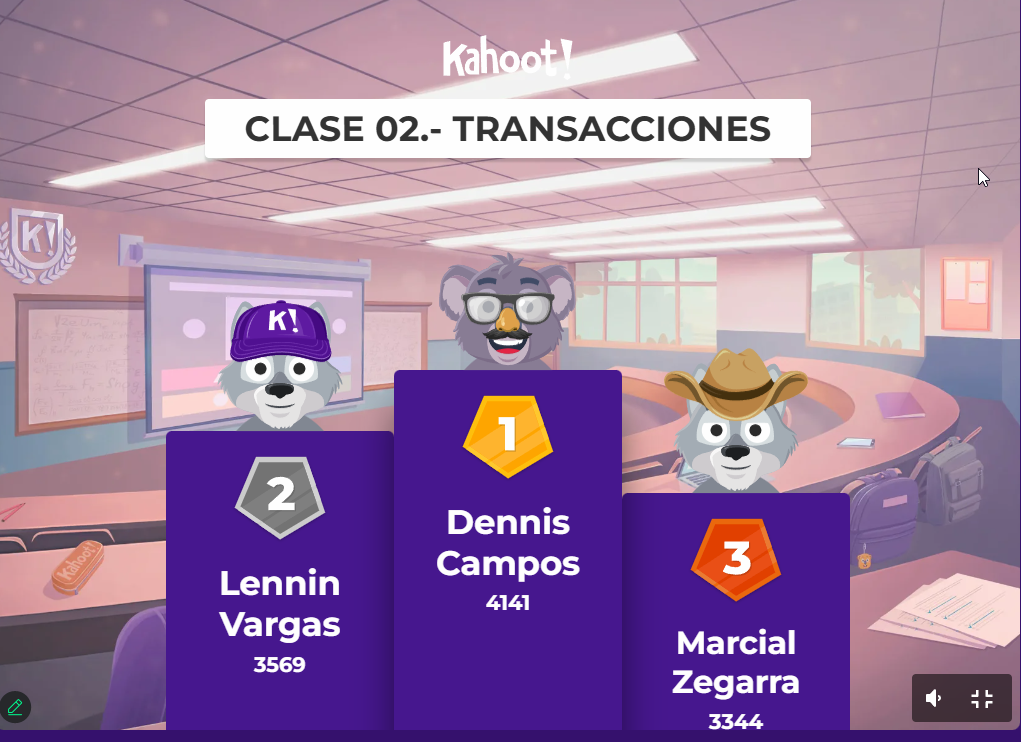